# Missing data
**Missing data** occur when no data value is stored for the variable. Missing values can be caused because the information is not reported, or the data is not recorded properly, or the information is not available. 

Taking following steps help to ensure missing data are correctly identified and properly dealt with:

### Step 1: Ensure your data are coded correctly
It is necessary to check if data are stored with proper data types (e.g., string, integer, datetime, etc.). 

### Step 2: Identify missing values within each variable
Missing values can be seen as Null, blank cells, special characters, or very large or low values (e.g., -999999). It is more convenient if all missing values are replaced and represented by one value (e.g., Null).

### Step 3: Patterns of missing values
- Observing any patterns in the missing data help to understand the cause of missing data occurrence and find a proper method to deal with them. 
- Missing data can be univariate or multivariate. A missing data pattern is said to be univariate if there is only one variable with missing data. 
- We also need to look at the randomness of missing data occurrences. Values are randomly missing, and they do not relate to any other variable in the dataset. Whereas, for not-random missing data, the pattern of missingness is related to other variables in the dataset (i.e., all data for variable A is missing where variable B is 'bb'). 
- Understanding the link between missing and observed data is important to find a proper method to deal with missing data. 

### Step 4: How to handle missing data
There are several factors that should be considered while choosing what to do with the missing data. Based on the information obtained through steps 1 & 2, one of the following approches can be considered:

- Delete the variable
- Delete the cases with missing data
- Replace the missing values

#### 4.1: Delete the variable
If a variable has >50 % missing data, it might be reasonable to remove the variable from the dataset, unless the variable is essential to the analysis and must remain in the dataset. 

#### 4.2: Delete the cases with missing data
It is the case for multivariate missing data where most of variable have missing values.

#### 4.3: Replace (impute) missing values
If it is decided to keep the variables and cases with missing values, they should be imputed (replaced by a value). 
- Missing values can be replaced by a constant number (usually central tendency parameters). 
    - Other variables can be used to achieve a more accurate estimation for missing values rather than using the mean/median value calculated for all data. For example, variable A can be grouped based on the variable B (a categorical feature), then missing data of variable A can be replaced by the average of variable A for each group.
- For univariate missing patterns, the relationship between the variables can also be used in a form of a modeling process to predict the missing values such as using a regression model to predict the missing value based on other variables.

In [1]:
import os
os.chdir('...\\missing_data')
%config Completer.use_jedi = False

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler

In [3]:
pd.options.display.float_format = "{:,.2f}".format

In [4]:
df=pd.read_csv('data_miss_imputation.csv')

Step 1: make sure data types are correctly assigned to the features

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   As      4608 non-null   int64  
 1   Au      4608 non-null   int64  
 2   Co      4608 non-null   int64  
 3   Cu      4608 non-null   int64  
 4   Fe      4608 non-null   float64
 5   Hg      4608 non-null   int64  
 6   Mn      4608 non-null   int64  
 7   Mo      4608 non-null   int64  
 8   Ni      4608 non-null   int64  
 9   U       4608 non-null   float64
 10  Zn      4608 non-null   int64  
 11  x       4608 non-null   float64
 12  y       4608 non-null   float64
dtypes: float64(4), int64(9)
memory usage: 468.1 KB


Step 2: Note that all data are reported as non-null; however, further investigation shows that most of the features contain negative values should be considered as null (missing) values. (Because each feature represents concentration of an element, and the element concentration must be positive value.)


In [6]:
df.describe().loc[['min','mean','max']]

,As,Au,Co,Cu,Fe,Hg,Mn,Mo,Ni,U,Zn,x,y
min,-1.00,-5.00,-2.00,-2.00,0.12,-10.00,25.00,-2.00,-2.00,-0.50,4.00,"424,337.83","6,046,218.87"
mean,2.45,3.31,11.36,32.24,3.13,62.34,790.15,2.18,26.49,4.13,98.76,"586,176.30","6,213,760.72"
max,76.00,112.00,190.00,"1,600.00",33.00,"1,560.00","89,000.00",69.00,280.00,130.00,"7,100.00","701,712.54","6,471,893.74"


In [7]:
# replacing negative values by numpy.nan 
for col in df.drop(['x','y'], axis=1).columns:
    df.loc[(df[col]<=0),[col]]=np.nan

In [8]:
# calculates the percentage of missing value for each feature (x and y represent the location of each entry)
((df.drop(['x','y'], axis=1).isnull().sum()/len(df))*100).sort_values()

Fe    0.00
Mn    0.00
Zn    0.00
Cu    0.02
U     0.11
Ni    0.39
Co    0.50
Hg    1.54
Mo   19.47
As   26.41
Au   48.24
dtype: float64

Au had the highest proportion of missing values (48%). Removing Au from the dataset is definitely justified given its high proportion of missing value; however, this feature is a critical variable for our research and must remain in the dataset. 

([], [])

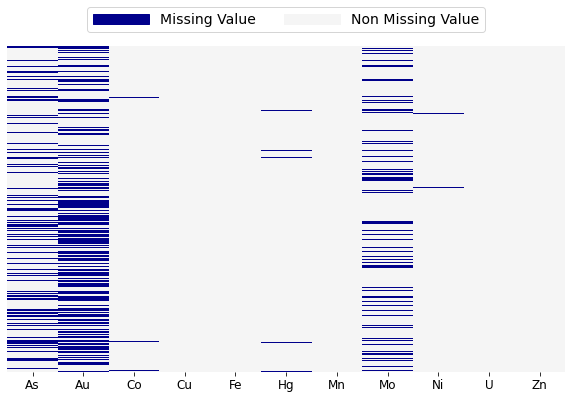

In [9]:
plt.figure(figsize=(10,6))
colors = [[False, "whitesmoke"],[True, "darkblue"]]
cm = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(df.drop(['x','y'], axis=1).isnull(), cmap=cm, cbar=False)

legend_handles = [Patch(color="darkblue", label='Missing Value'),Patch(color="whitesmoke", label='Non Missing Value')]
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=14, handlelength=4)

plt.xticks(fontsize=12)
plt.yticks([])

This plot is very helpful to identify multivariate missing pattern in the data. Blue bars represent missing value for each variable at each row. For the multivariate missing pattern, blue bars exist for most of the features at a row. The current dataset doesn't show this pattern. 

In [10]:
df_copy=df.copy()
gdf=gpd.GeoDataFrame(df_copy, geometry= gpd.points_from_xy(df['x'],df['y']))

To further investigate the pattern of missingness, the dataframe was converted to a geodataframe which can store geolocation information (x and y as geometries). 
Plotting the location of missing and non-missing data for two variables (Au and Mo) revealed that most of the missing Au values follow a pattern and are located in the upper portion of the area; whereas, distribution of missing values for the other features are completely random.

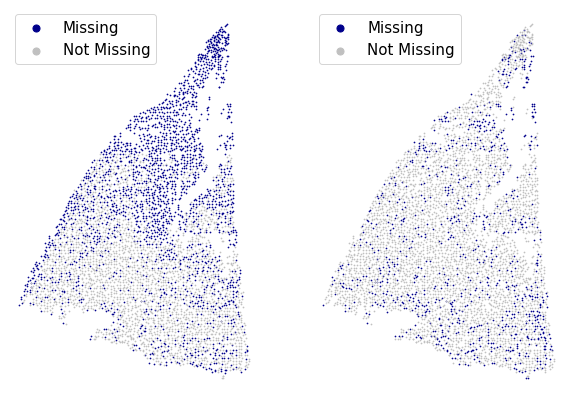

In [11]:
fig, axes=plt.subplots(1,2, figsize=(10,10))
gdf[gdf['Au'].isnull()].plot(ax=axes[0], color='darkblue', markersize=0.5, label='Missing')
gdf[gdf['Au'].notnull()].plot(ax=axes[0], color='silver', markersize=0.5, label='Not Missing')
axes[0].legend(markerscale=10, fontsize=15)
axes[0].set_axis_off()

gdf[gdf['Mo'].isnull()].plot(ax=axes[1], color='darkblue', markersize=0.5,label='Missing')
gdf[gdf['Mo'].notnull()].plot(ax=axes[1], color='silver', markersize=0.5, label='Not Missing')
axes[1].legend(markerscale=10, fontsize=15)
axes[1].set_axis_off()

For features with a random missingness pattern (all features except Au), the missing values were replaced by the average of 12 neighbouring values. 


In [12]:
# features with a random missingness pattern
missing_random=['As', 'Co', 'Cu', 'Fe', 'Hg', 'Mn', 'Mo', 'Ni', 'U', 'Zn']

In [13]:
from pointpats import PointPattern

In [14]:
# calculated the Euclidean distance between points and returns 12 closest points for each sample as its neighbours
pp = PointPattern([(p.x, p.y) for p in gdf.geometry])

# gets indices of 12 neighbours for each point. first array stores indices, second stores distance.
nearest_points=pp.knn(12)[0]

In [15]:
# replaces missing data with the average of neibouring values
for index, row in df.iterrows():
    for col in missing_random:
        if pd.isnull(row[col]):
            df.loc[index, col]= df.loc[nearest_points[index], col].mean()

In [16]:
# Au is the only feature with missing values 
((df.drop(['x','y'], axis=1).isnull().sum()/len(df))*100).sort_values()

As    0.00
Co    0.00
Cu    0.00
Fe    0.00
Hg    0.00
Mn    0.00
Mo    0.00
Ni    0.00
U     0.00
Zn    0.00
Au   48.24
dtype: float64

Given the observed pattern of missing Au values, they should be dealt with differently. 

1- The dataset was split into upper and lower portions. 
    - The lower portion contains non-missing values for all features. 
    - The upper portion contains non-missing values for all features except Au, and missing values for Au. 

2- A regressor was trained on the data from the lower portion to predict the missing Au values using other features. 

3- Then, the regressor was deployed to estimate missing Au values in the upper portion.  

4- Once, the missing data in the upper portion were imputed, the missing data in the lower portion could be replaced by the average of neighbouring values (like the other features) where unlike the upper portion it is possible for a point to have some non-missing value neighbours. 

In [17]:
lower_X= df.loc[(df['y']<6316649)& (df['Au'].notnull())].drop(['Au','x','y'], axis=1)
lower_y= df.loc[(df['y']<6316649)& (df['Au'].notnull()),'Au']

upper_X= df[df['y']>=6316649].drop(['Au','x','y'], axis=1)
# stores the indices of missing Au values to be replaced with the predicted values later
upper_X_indices= upper_X.index

In [19]:
# scales the data 
scaler=StandardScaler()
scaler.fit(lower_X)

lower_X=scaler.transform(lower_X)
upper_X=scaler.transform(upper_X)

# log transform of the target (au)
lower_y=np.log(lower_y.values)

In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [21]:
X_train, X_test, y_train, y_test=train_test_split(lower_X, lower_y, test_size=0.3)
svr=SVR()
svr.fit(X_train, y_train)

SVR()

Text(0, 0.5, 'Predicted Au values')

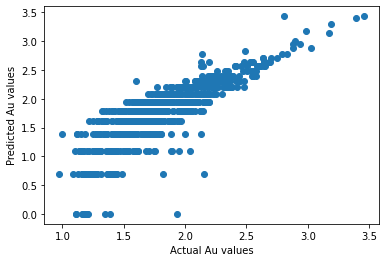

In [22]:
plt.scatter(svr.predict(X_test),y_test)
plt.xlabel("Actual Au values")
plt.ylabel("Predicted Au values")

In [23]:
print("R-squared score for training data: {:.2f}".format(r2_score(y_train, svr.predict(X_train))))
print("R-squared score for test data: {:.2f}".format(r2_score(y_test, svr.predict(X_test))))

R-squared score for training data: 0.74
R-squared score for test data: 0.67


In [24]:
# adds predicted values to geochem
df.loc[upper_X_indices, 'Au']= np.exp(svr.predict(upper_X))

In [25]:
# imputes missing Au data in the lower portion using neighbouring values
for index, row in df.iterrows():
    for col in ['Au']:
        if pd.isnull(row[col]):
            df.loc[index, col]= df.loc[nearest_points[index], col].mean()

In [26]:
# missing values are completely imputed 
((df.drop(['x','y'], axis=1).isnull().sum()/len(df))*100).sort_values()

As   0.00
Au   0.00
Co   0.00
Cu   0.00
Fe   0.00
Hg   0.00
Mn   0.00
Mo   0.00
Ni   0.00
U    0.00
Zn   0.00
dtype: float64

In [27]:
# the dataframe with imputed missing data. Ready for the next step of data processing
df.head()

,As,Au,Co,Cu,Fe,Hg,Mn,Mo,Ni,U,Zn,x,y
0,2.00,3.67,4.00,4.00,0.55,15.00,105.00,2.42,6.00,1.70,21.00,"424,337.83","6,134,066.04"
1,2.50,3.28,5.00,13.00,0.82,30.00,270.00,3.00,12.00,1.20,42.00,"427,093.64","6,141,874.88"
2,2.50,3.28,7.00,16.00,1.00,65.00,215.00,2.00,19.00,1.90,55.00,"427,416.54","6,144,102.47"
3,2.12,3.58,9.00,19.00,2.30,40.00,495.00,2.00,20.00,2.50,88.00,"428,367.09","6,136,264.12"
4,3.00,4.00,7.00,22.00,2.45,42.00,380.00,2.00,20.00,1.50,60.00,"429,670.69","6,138,023.03"
